In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler , RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib.ticker import MaxNLocator
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import os


# Importing custom functions
import sys
import os
root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_path)

from baseline.functions import load_data,create_intervals,create_windows,smape

# Loss folder path images
loss_folder = 'C:/Users/criju/Documents/Cod-Thesis-2/time_fm/loss-plots'
os.makedirs(loss_folder, exist_ok=True)

# Result folder path
result_folder = 'C:/Users/criju/Documents/Cod-Thesis-2/time_fm/results'
os.makedirs(result_folder, exist_ok=True)


In [2]:
import pandas as pd
import timesfm
import os
from huggingface_hub import login
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from dotenv import load_dotenv


load_dotenv()
hf_token = os.getenv("HUGGINGFACE_API_KEY")
# Log in with the token
login(token=hf_token)

TimesFM v1.2.0. See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded Jax TimesFM.
Loaded PyTorch TimesFM.


In [3]:
df = load_data('C:/Users/criju/Documents/Cod-Thesis-2/data/serie.csv')

# Global parameters
HORIZONTE_1 = 15 
HORIZONTE_2 = 30


intervalos_ordenados = create_intervals(df)


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/692 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Acumulando intervalos 1 a 1: MAE = 161.83, MSE = 39462.76


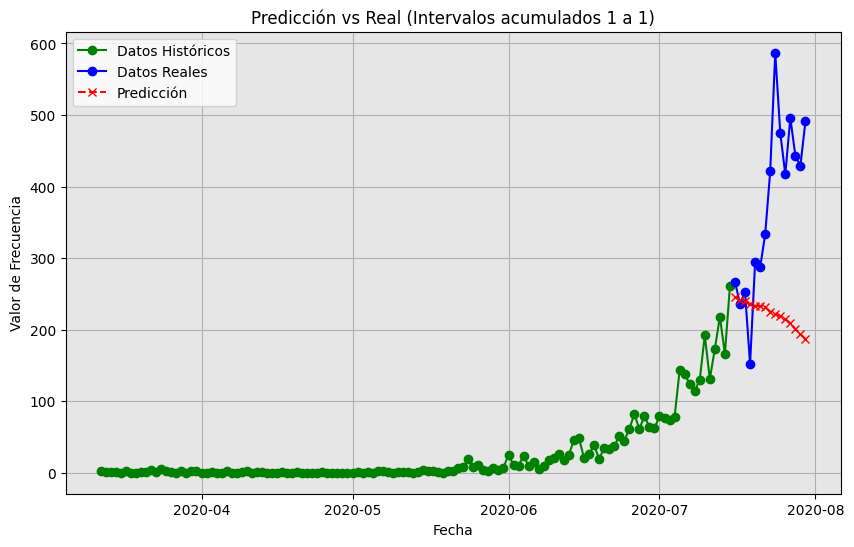

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Acumulando intervalos 1 a 2: MAE = 182.31, MSE = 49511.93


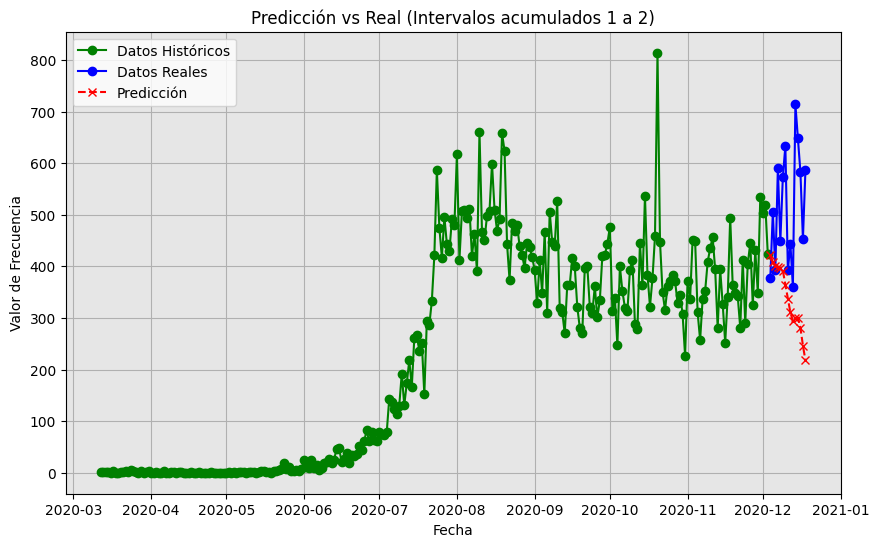

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Acumulando intervalos 1 a 3: MAE = 325.85, MSE = 181630.73


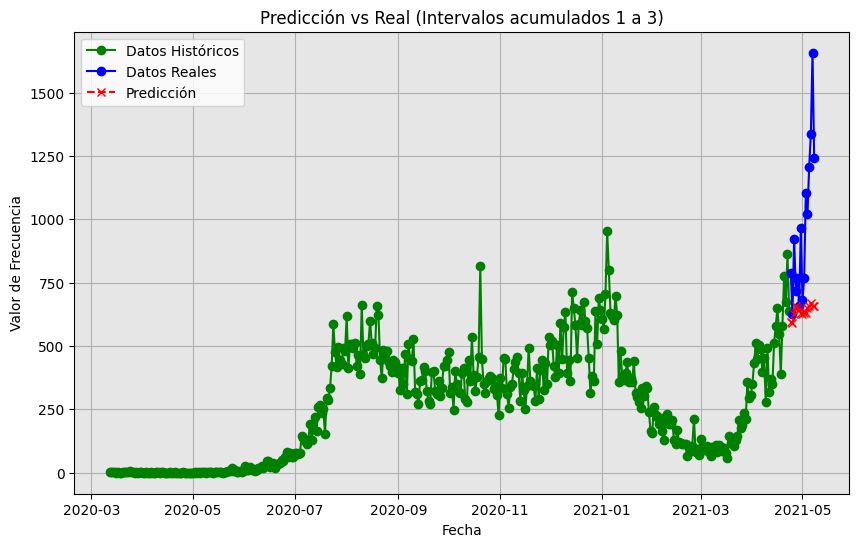

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Acumulando intervalos 1 a 4: MAE = 24.48, MSE = 633.61


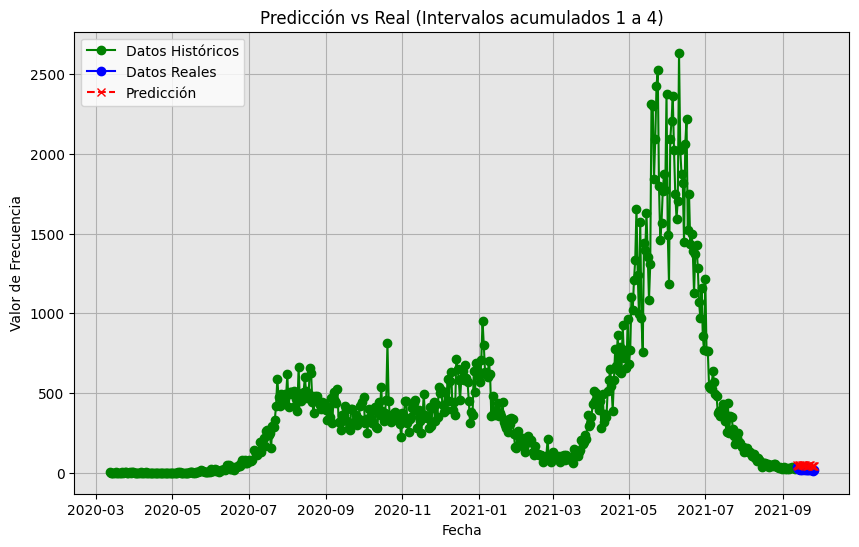

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Acumulando intervalos 1 a 5: MAE = 71.05, MSE = 10091.90


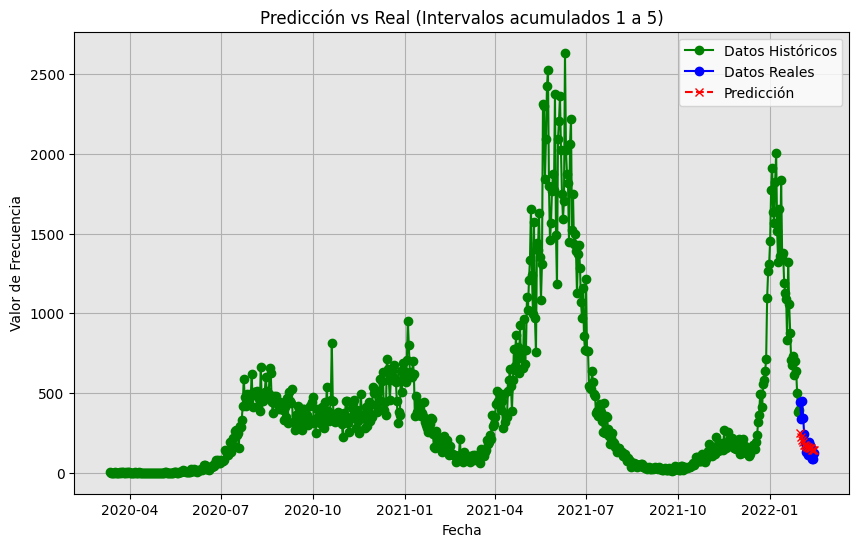

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Acumulando intervalos 1 a 6: MAE = 147.89, MSE = 22724.86


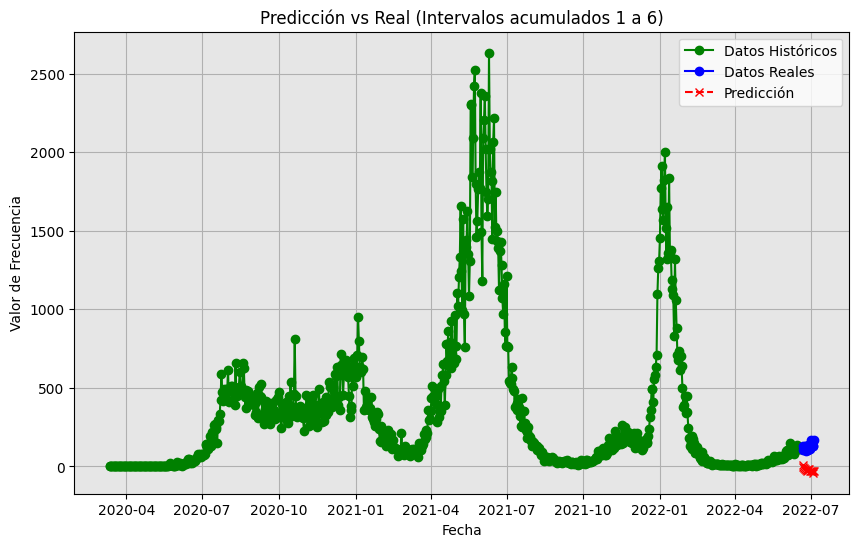

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Acumulando intervalos 1 a 7: MAE = 333.49, MSE = 145953.23


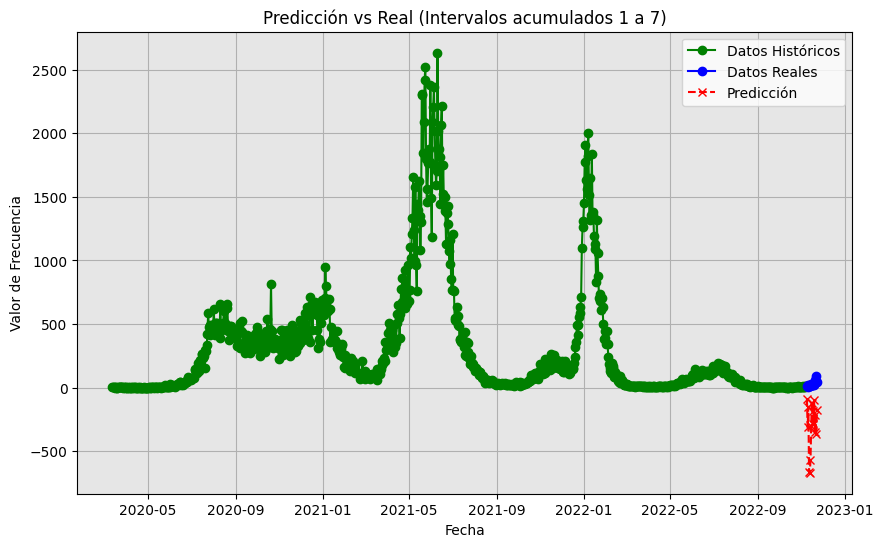

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Acumulando intervalos 1 a 8: MAE = 42.47, MSE = 1823.03


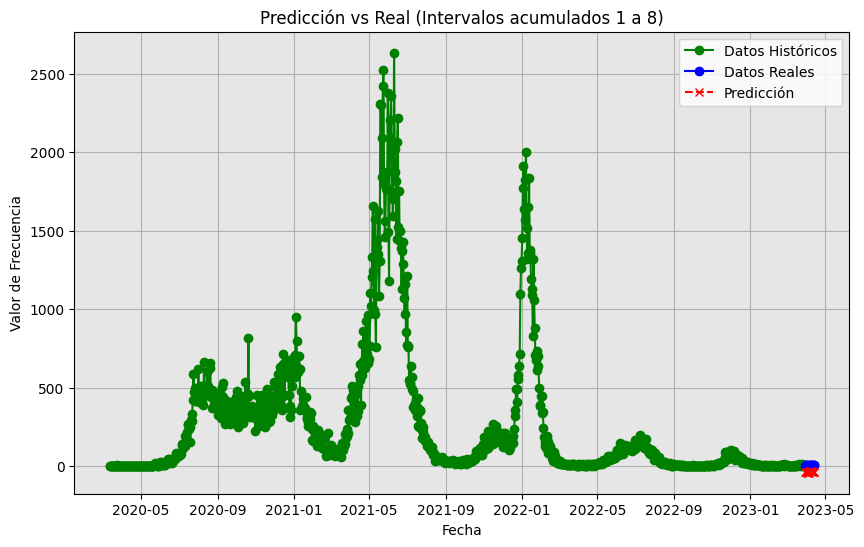


Resumen de métricas:
  Intervalos Acumulados         MAE            MSE       SMAPE
0      Intervalos 1 a 1  161.825472   39462.756060   49.959261
1      Intervalos 1 a 2  182.309046   49511.926689   41.510625
2      Intervalos 1 a 3  325.850155  181630.726523   36.128644
3      Intervalos 1 a 4   24.477538     633.607114   74.313470
4      Intervalos 1 a 5   71.046987   10091.895503   31.861227
5      Intervalos 1 a 6  147.888970   22724.858843  198.587973
6      Intervalos 1 a 7  333.494372  145953.230351  200.000000
7      Intervalos 1 a 8   42.473455    1823.030292  200.000000


In [4]:
resultados = []

tfm = timesfm.TimesFm(
    hparams=timesfm.TimesFmHparams(
        backend="gpu",
        per_core_batch_size=32,
        horizon_len=HORIZONTE_1,
        num_layers=50
    ),
    checkpoint=timesfm.TimesFmCheckpoint(
        version='torch',
        huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
)

# Bucle incremental para cada acumulación de intervalos
for i in range(len(intervalos_ordenados)):
   
    # Intervalos acumulados
    intervalos_incluir = intervalos_ordenados[:i+1]

    df_final = df[df['Intervalo'].isin(intervalos_incluir)]
    
    series = df_final['Frecuencia'].values.reshape(-1, 1)

    # Inicializamos el escalador y escalamos la serie
    scaler = StandardScaler()
    series_scaled = scaler.fit_transform(series)

    # Convertimos la serie escalada en un DataFrame
    df_scaled = pd.DataFrame(series_scaled, columns=['Frecuencia'])

    # Concatenamos la columna 'Fecha' con la columna escalada
    df_concatenado = pd.concat([df_final[['Fecha']].reset_index(drop=True), df_scaled], axis=1)

    df_train = df_concatenado.iloc[:-HORIZONTE_1].copy()
    df_test = df_concatenado.iloc[-HORIZONTE_1:].copy()

    # df_train = df_final.iloc[:-HORIZONTE].copy()
    # df_test = df_final.iloc[-HORIZONTE:].copy()

    # Preparing the data for training

    data_hist = df_train[['Fecha', 'Frecuencia']].rename(columns={
        'Fecha': 'ds',
        'Frecuencia': 'sales'
    })
    data_hist["unique_id"] = "series_1"

    forecast_df = tfm.forecast_on_df(
        inputs=data_hist,
        freq='D',
        forecast_context_len= len(data_hist),
        value_name='sales',
        num_jobs=-1)
    
    # 6. Alinear fechas y calcular métricas

    y_true = df_test['Frecuencia']
    y_pred = forecast_df['timesfm']
    
    y_pred = scaler.inverse_transform(y_pred.values.reshape(-1, 1))
    y_true = scaler.inverse_transform(y_true.values.reshape(-1, 1))


    # Calculamos las métricas
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    smape_value = smape(y_true, y_pred)

    resultados.append({
        'Intervalos Acumulados': f"Intervalos 1 a {i+1}",
        'MAE': mae,
        'MSE': mse,
        'SMAPE': smape_value
    })
    
    print(f"Acumulando intervalos 1 a {i+1}: MAE = {mae:.2f}, MSE = {mse:.2f}")
    
    # Graficar datos históricos, datos reales (test) y predicción sobre el intervalo completo
    fig, ax = plt.subplots(figsize=(10, 6))
    # Cambiar el color de fondo del eje a un gris suave
    ax.set_facecolor('#e6e6e6')  # Puedes ajustar el código hexadecimal para obtener el gris deseado

    # Graficar datos históricos (entrenamiento)
    # Aquí se vuelven a invertir las escalas para graficar los valores reales
    historico = scaler.inverse_transform(df_train['Frecuencia'].values.reshape(-1, 1))
    ax.plot(df_train['Fecha'], historico, label="Datos Históricos", marker='o', color='green')

    # Graficar datos reales del test (último intervalo)
    ax.plot(df_test['Fecha'], y_true, label="Datos Reales", marker='o', color='blue')

    # Graficar la predicción
    ax.plot(df_test['Fecha'], y_pred, label="Predicción", marker='x', linestyle='--', color='red')

    # Etiquetas y detalles de la gráfica
    ax.set_title(f"Predicción vs Real (Intervalos acumulados 1 a {i+1})")
    ax.set_xlabel("Fecha")
    ax.set_ylabel("Valor de Frecuencia")
    ax.legend()
    ax.grid(True)

    plt.show()



df_resultados = pd.DataFrame(resultados)
print("\nResumen de métricas:")
print(df_resultados) 


subfolder1_path = os.path.join(result_folder, "times_fm_results")
os.makedirs(subfolder1_path, exist_ok=True)


# Ruta completa al archivo dentro de la subcarpeta
csv_path = os.path.join(subfolder1_path, "times_fm_15.csv")

# Guardar el DataFrame en esa ruta
df_resultados.to_csv(csv_path, index=False)


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Acumulando intervalos 1 a 1: MAE = 198.98, MSE = 63915.55


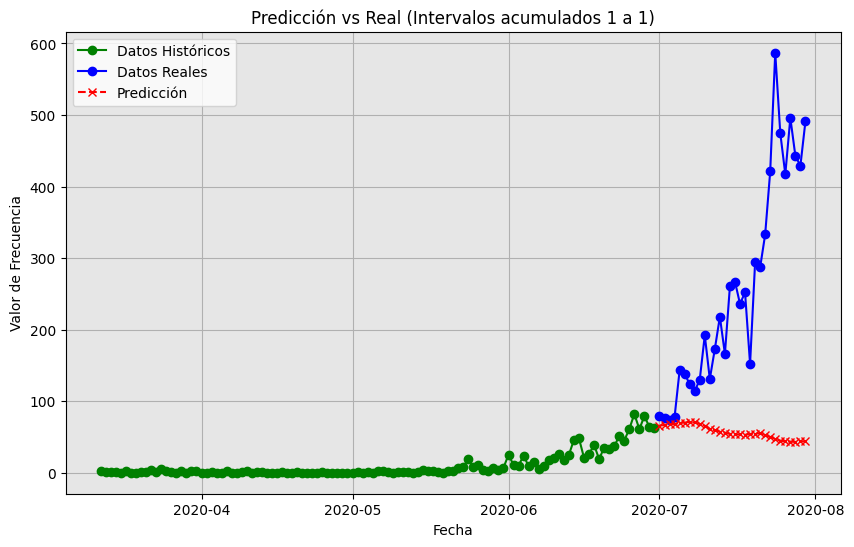

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Acumulando intervalos 1 a 2: MAE = 187.74, MSE = 54103.99


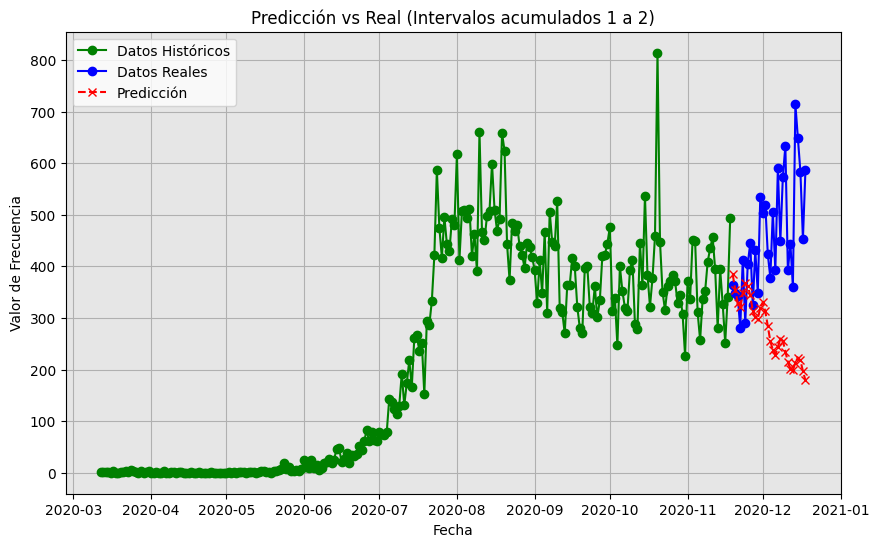

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Acumulando intervalos 1 a 3: MAE = 316.29, MSE = 172403.08


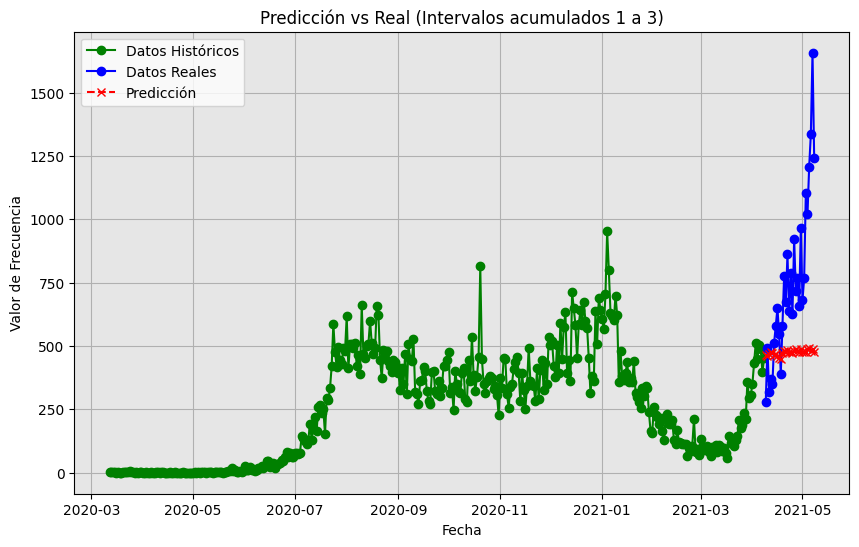

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Acumulando intervalos 1 a 4: MAE = 40.41, MSE = 1923.60


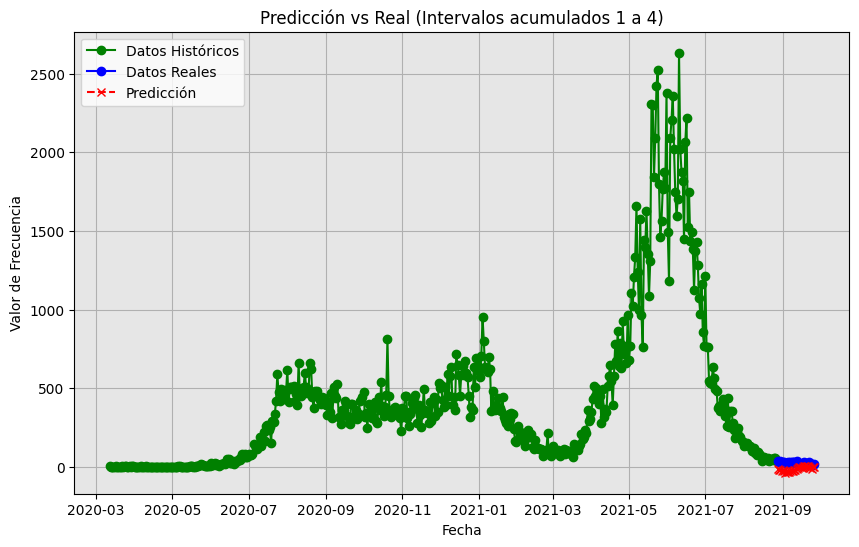

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Acumulando intervalos 1 a 5: MAE = 385.63, MSE = 165428.23


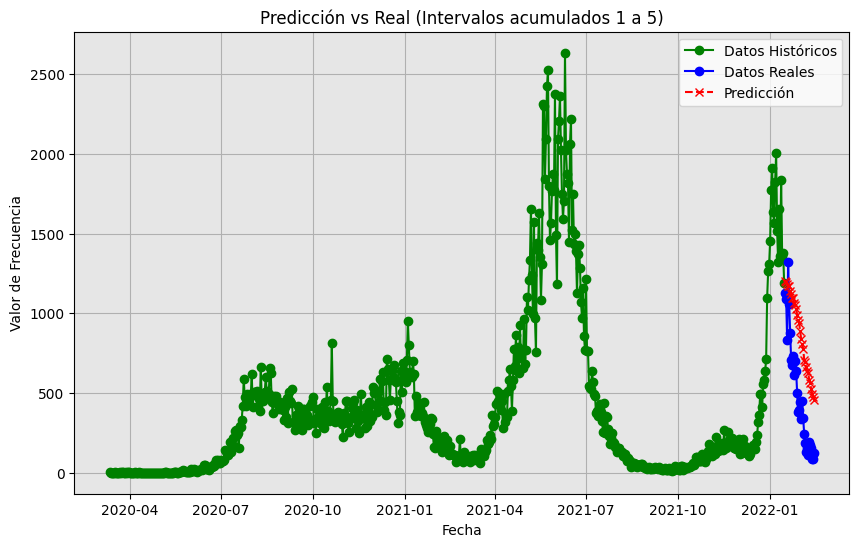

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Acumulando intervalos 1 a 6: MAE = 151.10, MSE = 23289.36


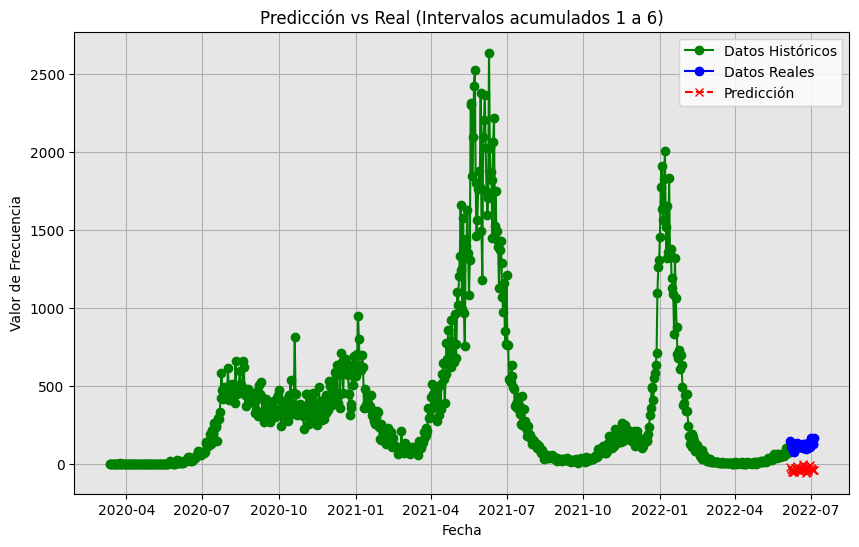

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Acumulando intervalos 1 a 7: MAE = 416.36, MSE = 263496.46


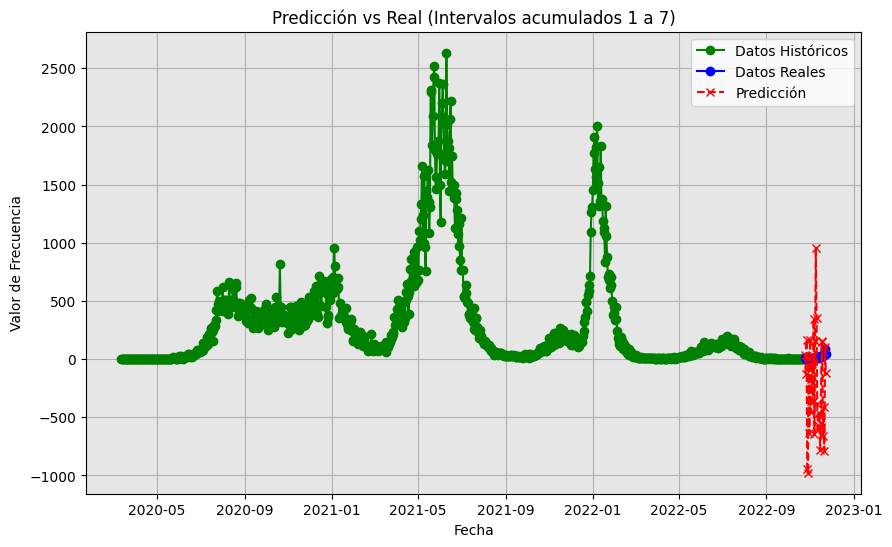

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Acumulando intervalos 1 a 8: MAE = 61.51, MSE = 3840.70


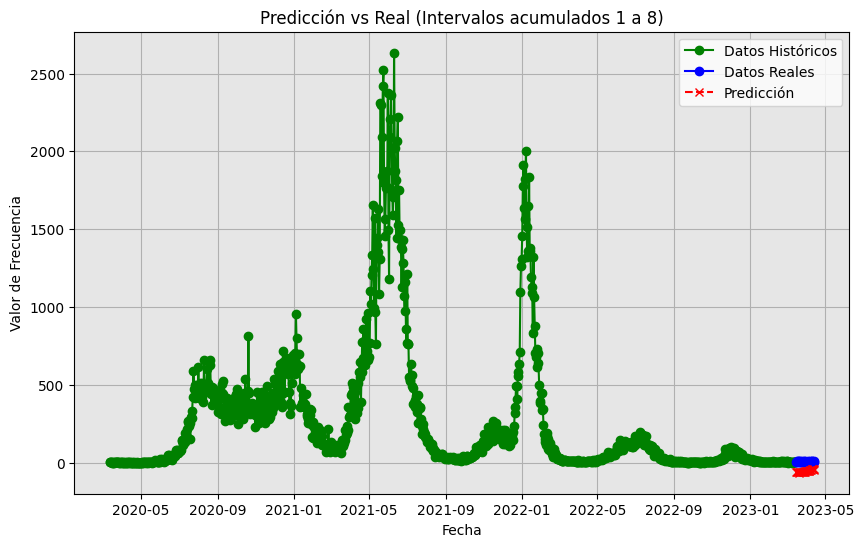


Resumen de métricas:
  Intervalos Acumulados         MAE            MSE       SMAPE
0      Intervalos 1 a 1  198.981252   63915.551630  106.293304
1      Intervalos 1 a 2  187.735085   54103.989123   49.306068
2      Intervalos 1 a 3  316.286175  172403.075819   45.561080
3      Intervalos 1 a 4   40.408743    1923.598096  191.138811
4      Intervalos 1 a 5  385.632317  165428.229360   73.704117
5      Intervalos 1 a 6  151.101106   23289.355805  199.846633
6      Intervalos 1 a 7  416.363683  263496.464342  182.115542
7      Intervalos 1 a 8   61.508645    3840.698116  200.000000


In [6]:
resultados = []

tfm = timesfm.TimesFm(
    hparams=timesfm.TimesFmHparams(
        backend="gpu",
        per_core_batch_size=32,
        horizon_len=HORIZONTE_2,
        num_layers=50
    ),
    checkpoint=timesfm.TimesFmCheckpoint(
        version='torch',
        huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
)

# Bucle incremental para cada acumulación de intervalos
for i in range(len(intervalos_ordenados)):
   
    # Intervalos acumulados
    intervalos_incluir = intervalos_ordenados[:i+1]

    df_final = df[df['Intervalo'].isin(intervalos_incluir)]
    
    series = df_final['Frecuencia'].values.reshape(-1, 1)

    # Inicializamos el escalador y escalamos la serie
    scaler = StandardScaler()
    series_scaled = scaler.fit_transform(series)

    # Convertimos la serie escalada en un DataFrame
    df_scaled = pd.DataFrame(series_scaled, columns=['Frecuencia'])

    # Concatenamos la columna 'Fecha' con la columna escalada
    df_concatenado = pd.concat([df_final[['Fecha']].reset_index(drop=True), df_scaled], axis=1)

    df_train = df_concatenado.iloc[:-HORIZONTE_2].copy()
    df_test = df_concatenado.iloc[-HORIZONTE_2:].copy()

    # df_train = df_final.iloc[:-HORIZONTE].copy()
    # df_test = df_final.iloc[-HORIZONTE:].copy()

    # Preparing the data for training

    data_hist = df_train[['Fecha', 'Frecuencia']].rename(columns={
        'Fecha': 'ds',
        'Frecuencia': 'sales'
    })
    data_hist["unique_id"] = "series_1"

    forecast_df = tfm.forecast_on_df(
        inputs=data_hist,
        freq='D',
        forecast_context_len= len(data_hist),
        value_name='sales',
        num_jobs=-1)
    
    # 6. Alinear fechas y calcular métricas

    y_true = df_test['Frecuencia']
    y_pred = forecast_df['timesfm']
    
    y_pred = scaler.inverse_transform(y_pred.values.reshape(-1, 1))
    y_true = scaler.inverse_transform(y_true.values.reshape(-1, 1))


    # Calculamos las métricas
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    smape_value = smape(y_true, y_pred)

    resultados.append({
        'Intervalos Acumulados': f"Intervalos 1 a {i+1}",
        'MAE': mae,
        'MSE': mse,
        'SMAPE': smape_value
    })
    
    print(f"Acumulando intervalos 1 a {i+1}: MAE = {mae:.2f}, MSE = {mse:.2f}")
    
    # Graficar datos históricos, datos reales (test) y predicción sobre el intervalo completo
    fig, ax = plt.subplots(figsize=(10, 6))
    # Cambiar el color de fondo del eje a un gris suave
    ax.set_facecolor('#e6e6e6')  # Puedes ajustar el código hexadecimal para obtener el gris deseado

    # Graficar datos históricos (entrenamiento)
    # Aquí se vuelven a invertir las escalas para graficar los valores reales
    historico = scaler.inverse_transform(df_train['Frecuencia'].values.reshape(-1, 1))
    ax.plot(df_train['Fecha'], historico, label="Datos Históricos", marker='o', color='green')

    # Graficar datos reales del test (último intervalo)
    ax.plot(df_test['Fecha'], y_true, label="Datos Reales", marker='o', color='blue')

    # Graficar la predicción
    ax.plot(df_test['Fecha'], y_pred, label="Predicción", marker='x', linestyle='--', color='red')

    # Etiquetas y detalles de la gráfica
    ax.set_title(f"Predicción vs Real (Intervalos acumulados 1 a {i+1})")
    ax.set_xlabel("Fecha")
    ax.set_ylabel("Valor de Frecuencia")
    ax.legend()
    ax.grid(True)

    plt.show()



df_resultados = pd.DataFrame(resultados)
print("\nResumen de métricas:")
print(df_resultados) 


subfolder1_path = os.path.join(result_folder, "times_fm_results")
os.makedirs(subfolder1_path, exist_ok=True)


# Ruta completa al archivo dentro de la subcarpeta
csv_path = os.path.join(subfolder1_path, "times_fm_30.csv")

# Guardar el DataFrame en esa ruta
df_resultados.to_csv(csv_path, index=False)
